In [39]:
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tfd = tfp.distributions
tfb = tfp.bijectors

# tfp.distributions

## tfd.Normal

In [3]:
dist = tfd.Normal(loc=1, scale=3)

x = [0.5, 1., 2.8]
print('two samples:', dist.sample(2).numpy())
print('prob:', dist.prob(x).numpy()) 
print('log_prob:', dist.log_prob(x).numpy())
print('cdf:', dist.cdf(x).numpy())

two samples: [4.6266284 2.802314 ]
prob: [0.13114657 0.13298075 0.11107485]
log_prob: [-2.0314398 -2.017551  -2.197551 ]
cdf: [0.43381616 0.5        0.72574687]


### Caution on shape

In [7]:
loc = np.array([0,1,2], dtype='float32').reshape((3,1))
dist = tfd.Normal(loc=loc, scale=1.)

`dist.batch_shape` is (3,1). 

Thus when we compute `dist.prob(x)`, `x.shape[0]` should be 3; otherwise, `x` is properly broadcasted.

In [9]:
dist.prob(4)  # same as dist.prob([[4,],[4,],[4,]])

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.00013383],
       [0.00443185],
       [0.05399096]], dtype=float32)>

In [10]:
dist.prob([4, 10])   
# same as dist.prob([[4,10],[4,10],[4,10]])
# same as tf.concat([dist.prob(4), dist.prob(10)], axis=1)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1.3383021e-04, 7.6946054e-23],
       [4.4318479e-03, 1.0279782e-18],
       [5.3990960e-02, 5.0522754e-15]], dtype=float32)>

In [ ]:
dist.prob([[4,],[10,]])
# InvalidArgumentError: Incompatible shapes: [2,1] vs. [3,1] [Op:SquaredDifference]

In [11]:
dist2 = tfd.Normal(loc=[0,1,2], scale=1)
# dist2.batch_shape is (3,)

In [13]:
dist2.prob(4)    # same as dist2.prob([4,4,4])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.00013383, 0.00443185, 0.05399096], dtype=float32)>

In [ ]:
dist2.prob([4, 10])
# InvalidArgumentError: Incompatible shapes: [2] vs. [3] [Op:SquaredDifference]

In [15]:
dist2.prob([[4,],[10,]]) # same as dist2.prob([[4,4,4],[10,10,10]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.3383021e-04, 4.4318479e-03, 5.3990960e-02],
       [7.6946054e-23, 1.0279782e-18, 5.0522754e-15]], dtype=float32)>

## tfd.Deterministic

* pmf(x; loc) = 1, if x == loc, else 0 
* cdf(x; loc) = 1, if x >= loc, else 0 

In [5]:
constant = tfd.Deterministic(0.)
    # const.prob(x) is 1 if x is 0
    # const.prob(x) is 0 otherwise
print(constant.prob(0.).numpy(), constant.prob(2.).numpy())

1.0 0.0


In [6]:
loc = [[0., 1.], [2., 3.]] 
x = [[0., 1.1], [1.99, 3.]] 
constant = tfd.Deterministic(loc)
    # tfd.Deterministic(loc) is equal to 
    # [[tfd.Deterministic(loc[0,0]), tfd.Deterministic(loc[0,1])],
    #  [tfd.Deterministic(loc[1,0]), tfd.Deterministic(loc[1,1])]]
constant.prob(x) 

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

## tfd.Mixture

In [17]:
out = tf.random.normal((5,2))

rate = tf.math.exp(out[:, 0])
s = tf.math.sigmoid(out[:, 1:2])
probs = tf.concat([1-s, s], axis=1)
dist = tfd.Mixture(
    cat = tfd.Categorical(probs=probs),
    components = [tfd.Deterministic(loc=tf.zeros_like(rate)), tfd.Poisson(rate=rate)])

dist.batch_shape

TensorShape([5])

If we use `rate` of 2D shape in the above, that is, if `rate = tf.math.exp(out[:,0:1])`, then we have the following error:

ValueError: components[0] batch shape must be compatible with cat shape and other component batch shapes ((5,) vs (5, 1))

# tfp.bijectors

Bijective transformations

In [24]:
s = tfb.Square()
print(s.forward(3.))
print(s.inverse(5.))

tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(2.236068, shape=(), dtype=float32)


## Shift(), Scale()

* Y = g(X; shift) = X + shift
* Y = g(X; scale) = scale * X

## Permute()

Permutes the rightmost dimension of a Tensor.

For example, if X is a tensor of shape (m, 3) and `Y = tfb.Permute([1,2,0])(X)`, then `Y[:,0]` is `X[:,1]`, `Y[:,1]` is `X[:,2]`, and `Y[:,2]` is `X[:,0]`.

## Chain()

Bijector which applies a sequence of bijectors.

For example,

```python
chain = Chain([Exp(), Softplus()])
chain.forward(x)
```

is equal to 

```
Exp().forward(Softplus().forward(x))
```

## SinhArcsinh()

Y = g(X) = Sinh( (Arcsinh(X) + skewness) * tailweight ) * multiplier.

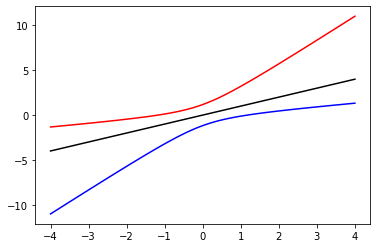

In [49]:
x = np.linspace(-4, 4, 100, dtype='float32')
plt.plot(x, tfb.SinhArcsinh(skewness=0, tailweight=1).forward(x), c='black')
plt.plot(x, tfb.SinhArcsinh(skewness=1, tailweight=1).forward(x), c='red')
plt.plot(x, tfb.SinhArcsinh(skewness=-1, tailweight=1).forward(x), c='blue')
plt.show()

## RealNVP()

Real Non-Volume Preserving flow.

Real NVP models a normalizing flow on a $D$-dimensional distribution via a single $(D-d)$-dimensional conditional distribution.

* $Y[:,:d] = X[:,:d]$

* $Y[:,d:D] = X[:,d:D] * \exp(log\_scale\_fn(X[:,:d])) + shift\_fn(X[:,:d])$

* The scale and shift functions from $\mathbb{R}^{d}$ to $\mathbb{R}^{D-d}$ are controlled by an NN.

### real_nvp_default_template()

`tfb.real_nvp_default_template()` builds a scale-and-shift function using a multi-layer neural network. It takes the $d$-dimensional input and returns the $(D-d)$-dimensional outputs and log_scale and shift.

In [57]:
bij = tfb.RealNVP(num_masked = 2,
                  shift_and_log_scale_fn = tfb.real_nvp_default_template(hidden_layers=[32, 16]))

bij.forward(tf.constant(np.arange(20).reshape((-1, 5)).astype('float32'))).numpy().round(2)

array([[  0.  ,   1.  ,   1.59,   3.11,   3.07],
       [  5.  ,   6.  ,   1.87,  16.78,   1.88],
       [ 10.  ,  11.  ,   0.4 ,  56.34,   2.34],
       [ 15.  ,  16.  ,  -1.46, 156.63,   3.25]], dtype=float32)

## Training bijectors

Reference: https://github.com/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_03.ipynb


### Affine transformation

* Observation: $X$ from $N(5, 0.2)$
* Train $a$ and $b$ such that $z \sim N(0, 1) \to x = a z + b \sim N(5, 0.2)$

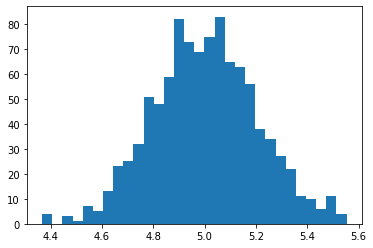

In [35]:
N = 1000
X = tfd.Normal(loc=5, scale=0.2).sample(1000)
X = X.numpy().reshape([N,1])

plt.hist(X, 30);

In [36]:
# Find a and b such that x ~ N(a, b)

b = tf.Variable(0.0)
a = tf.Variable(1.0)
bijector = tfb.Shift(b)(tfb.Scale(a))
dist = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0, scale=1), bijector=bijector)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1) #quite high lr for normalizing flows.

for i in range(1000):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(X))
        gradients = tape.gradient(loss, dist.trainable_variables)
        optimizer.apply_gradients(zip(gradients, dist.trainable_variables))
    if (i % 100 == 0):
        print(i, "NLL ", loss.numpy(), " shift (a) ", a.numpy(), " scale (b) ", b.numpy())

0 NLL  13.449111  shift (a)  1.1  scale (b)  0.09999994
100 NLL  1.9126384  shift (a)  2.4532535  scale (b)  3.9808757
200 NLL  0.27638745  shift (a)  0.43125576  scale (b)  5.003593
300 NLL  -0.17771575  shift (a)  0.20268275  scale (b)  5.0019073
400 NLL  -0.17772247  shift (a)  0.20257036  scale (b)  5.0019307
500 NLL  -0.1777225  shift (a)  0.2025719  scale (b)  5.0019307
600 NLL  -0.1777225  shift (a)  0.20257188  scale (b)  5.0019307
700 NLL  -0.1777225  shift (a)  0.20257188  scale (b)  5.0019307
800 NLL  -0.1777225  shift (a)  0.20257188  scale (b)  5.0019307
900 NLL  -0.1777225  shift (a)  0.20257188  scale (b)  5.0019307


In [37]:
a.numpy(), b.numpy()

(0.2025719, 5.0019307)

### Fitting the old faithful

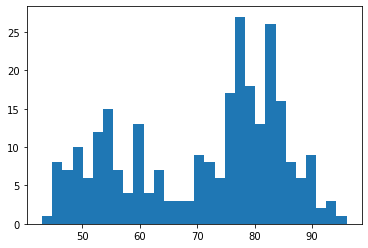

In [50]:
X = pd.read_csv('data/faithful.csv', delimiter=',')['waiting'].values.astype('float32')[:,np.newaxis]
plt.hist(X, bins=30);

Here we chain the bijectors of the form $a_i sinh( (arcsinh(x) + c_i ) d_i ) + b_i$ five times.

0 NLL  2606.187
1 NLL  1541.5117
2 NLL  962.572
3 NLL  635.1126
4 NLL  440.90366
2000 NLL  4.3869534
4000 NLL  4.1083465
6000 NLL  4.0207644
8000 NLL  3.9419417
10000 NLL  3.8819408
12000 NLL  3.840745
14000 NLL  3.8216517
16000 NLL  3.8070526
18000 NLL  3.8042836


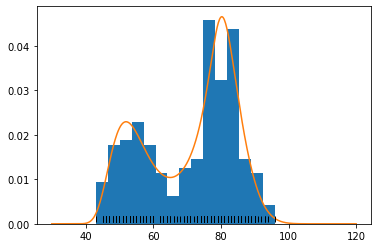

In [46]:
from tensorflow.keras.optimizers import Adam

num_bijectors = 5
bs = []
for i in range(num_bijectors):
    shift, scale = tf.Variable(0.), tf.Variable(1.)
    bs.append(tfb.Shift(shift)(tfb.Scale(scale)))

    skewness, tailweight = tf.Variable(0.), tf.Variable(1.)
    bs.append(tfb.SinhArcsinh(skewness, tailweight))

bijector = tfb.Chain(bs)

dist = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0, scale=1), bijector=bijector)
optimizer = Adam(learning_rate=0.01)

@tf.function
def train_step(X):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(X))
        gradients = tape.gradient(loss, dist.trainable_variables)
        optimizer.apply_gradients(zip(gradients, dist.trainable_variables))
    return loss

for i in range(20000):
    loss = train_step(X)
    if i%2000==0 or i<5:
        print(i, "NLL ", loss.numpy())

plt.hist(X, 15, density=True) 
xs = np.linspace(30, 120, 500) 
plt.plot(xs, dist.prob(xs)) 
plt.plot(X, [0.001]*len(X), '|', color='k')
plt.show()

### RealNVP Example

Reference: https://github.com/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_04.ipynb

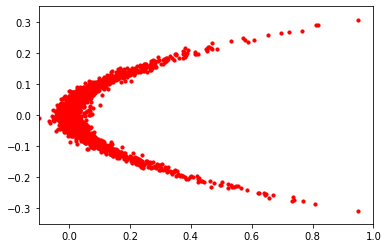

In [51]:
def make_sample(batch_size=500):
    x2_samples = tfd.Normal(loc=0., scale=4.).sample(batch_size)
    x1_samples = tfd.Normal(loc=.25 * tf.square(x2_samples), scale=1.).sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)   # (batch_size, 2)
    return x_samples.numpy() / 40.0

X = make_sample(1500) 
plt.scatter(X[:,0], X[:,1], s=10, color='red') 
plt.xlim(-0.1,1) 
plt.ylim(-0.35,0.35) 
plt.show()

In [74]:
class RealNVP(tf.keras.models.Model):
    def __init__(self, hidden_layers=[32,32], num_masked=1, **kwargs):
        super().__init__(**kwargs)
        self.hidden_layers = hidden_layers
        self.nets = []

        bijectors = []
        num_blocks = 5

        for i in range(num_blocks):
            net = tfb.real_nvp_default_template(hidden_layers)
            bijectors.append(tfb.Permute([1,0]))            
            bijectors.append(tfb.RealNVP(shift_and_log_scale_fn=net, num_masked=num_masked))
            self.nets.append(net)

        bijector = tfb.Chain(bijectors)
        # Permute, RealNVP, Permute, ..., Permute, RealNVP
        
        self.flow = tfd.TransformedDistribution(
            distribution = tfd.MultivariateNormalDiag(loc=[0., 0.]), 
            bijector=bijector)

    def call(self, *inputs):
        return self.flow.bijector.forward(*inputs)


model = RealNVP()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

##### Important 
# Needs to be called otherwise @tf.function has problem 
model.flow.prob(X) 


@tf.function
def train_step(X):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
     
from time import time 
start = time() 
for i in range(1001):
    loss = train_step(X)
    if (i % 100 == 0):
        print(i, " ", loss.numpy(), (time()-start))
        start = time()

0   1.8082764 2.524209499359131
100   -2.1393697 0.3623991012573242
200   -3.1805127 0.3538060188293457
300   -3.1952446 0.3481881618499756
400   -3.2003925 0.3535585403442383
500   -3.2038763 0.35565853118896484
600   -3.2060273 0.3580770492553711
700   -3.206774 0.349592924118042
800   -3.209484 0.39061927795410156
900   -3.2104275 0.4033050537109375
1000   -3.2109606 0.367816686630249


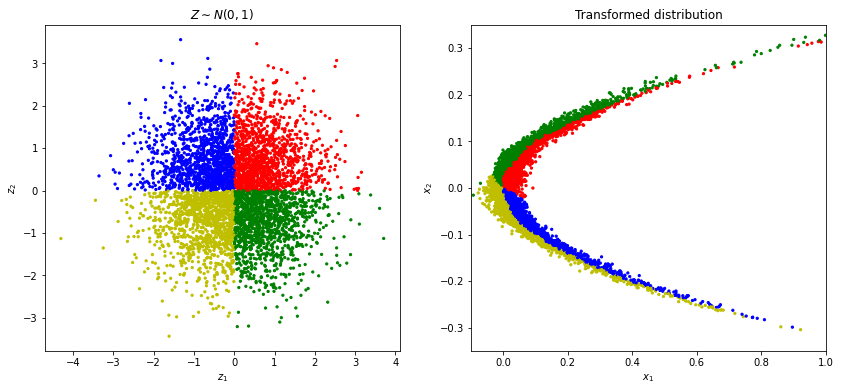

In [78]:
#Z = np.random.normal(0, 1, (5000,2)).astype('float32') 
Z = tfd.MultivariateNormalDiag([0.,0.]).sample(5000).numpy()

cols = [] 
for i in range(5000):
    if (Z[i,0] > 0 and Z[i,1] > 0):
        cols.append('r')
    elif (Z[i,0] < 0 and Z[i,1] > 0):
        cols.append('b')
    elif (Z[i,0] < 0 and Z[i,1] < 0):
        cols.append('y')
    else:
        cols.append('g')

plt.figure(figsize=(14,6)) 
plt.subplot(1,2,1) 
plt.scatter(Z[:, 0], Z[:, 1], s=5, c=cols) 
plt.title('$Z \sim N(0,1)$') 
plt.xlabel('$z_1$') 
plt.ylabel('$z_2$') 

Xs = model(Z)
plt.subplot(1,2,2) 
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=cols) 
plt.title('Transformed distribution') 
plt.xlabel('$x_1$') 
plt.ylabel('$x_2$') 
plt.xlim(-0.1,1) 
plt.ylim(-0.35,0.35);